# Predictive Analysis of Customer Term Deposit Subscription Behavior

####      by Susu Ping & Yuze Li


#Load the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import graphviz

In [2]:
data = pd.read_csv('bank-additional-full.csv', sep=';' )
print(data.head())

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed

In [3]:
columns_to_drop = ['day_of_week', 'month', 'cons.price.idx', 'euribor3m', 'contact', 'previous', 'emp.var.rate']
data_cleaned = data.drop(columns=columns_to_drop, errors='ignore')
print(data_cleaned.head())

   age        job  marital    education  default housing loan  duration  \
0   56  housemaid  married     basic.4y       no      no   no       261   
1   57   services  married  high.school  unknown      no   no       149   
2   37   services  married  high.school       no     yes   no       226   
3   40     admin.  married     basic.6y       no      no   no       151   
4   56   services  married  high.school       no      no  yes       307   

   campaign  pdays     poutcome  cons.conf.idx  nr.employed   y  
0         1    999  nonexistent          -36.4       5191.0  no  
1         1    999  nonexistent          -36.4       5191.0  no  
2         1    999  nonexistent          -36.4       5191.0  no  
3         1    999  nonexistent          -36.4       5191.0  no  
4         1    999  nonexistent          -36.4       5191.0  no  


In [4]:
print(data_cleaned.columns)

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'duration', 'campaign', 'pdays', 'poutcome', 'cons.conf.idx',
       'nr.employed', 'y'],
      dtype='object')


In [6]:
print(data_cleaned.describe())

               age      duration      campaign         pdays  cons.conf.idx  \
count  41188.00000  41188.000000  41188.000000  41188.000000   41188.000000   
mean      40.02406    258.285010      2.567593    962.475454     -40.502600   
std       10.42125    259.279249      2.770014    186.910907       4.628198   
min       17.00000      0.000000      1.000000      0.000000     -50.800000   
25%       32.00000    102.000000      1.000000    999.000000     -42.700000   
50%       38.00000    180.000000      2.000000    999.000000     -41.800000   
75%       47.00000    319.000000      3.000000    999.000000     -36.400000   
max       98.00000   4918.000000     56.000000    999.000000     -26.900000   

        nr.employed  
count  41188.000000  
mean    5167.035911  
std       72.251528  
min     4963.600000  
25%     5099.100000  
50%     5191.000000  
75%     5228.100000  
max     5228.100000  


In [7]:
print(data_cleaned['default'].value_counts())

default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64


In [8]:
missing_values = data.isnull().sum()
missing_values

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

#EDA

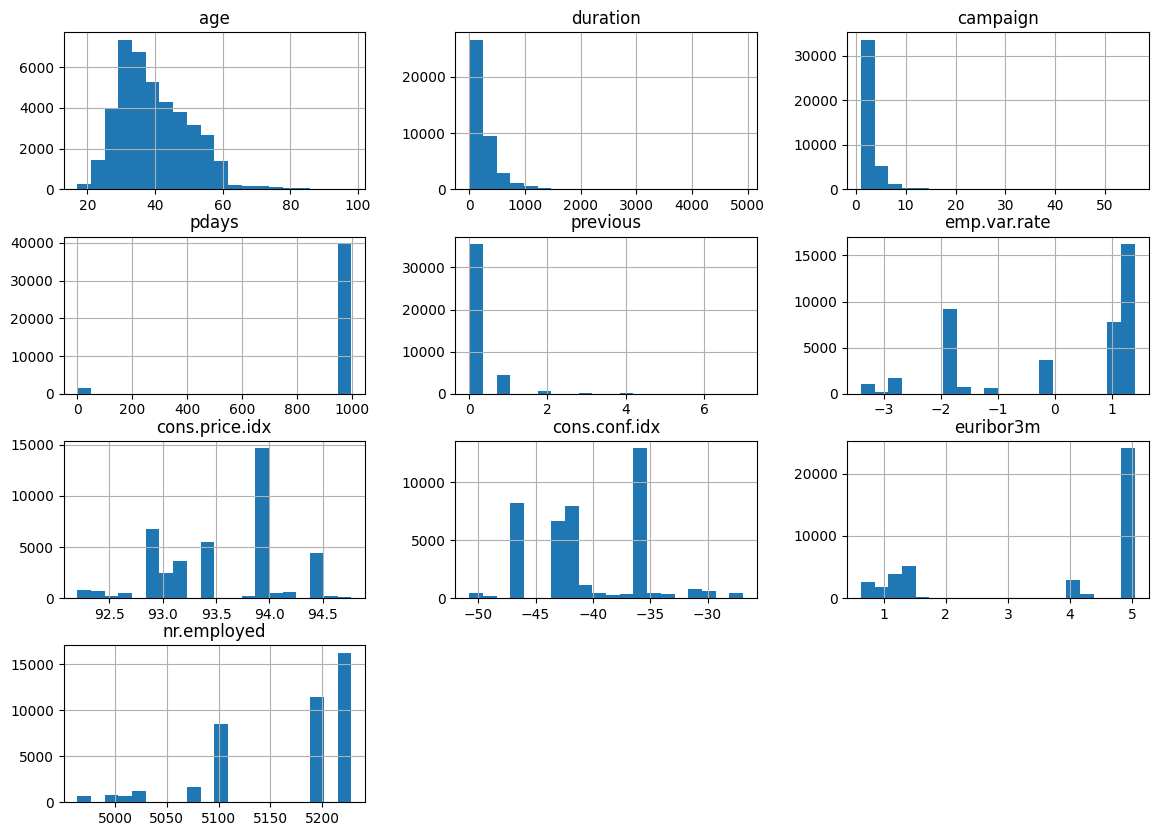

In [9]:
data.hist(bins=20, figsize=(14, 10))
plt.show()

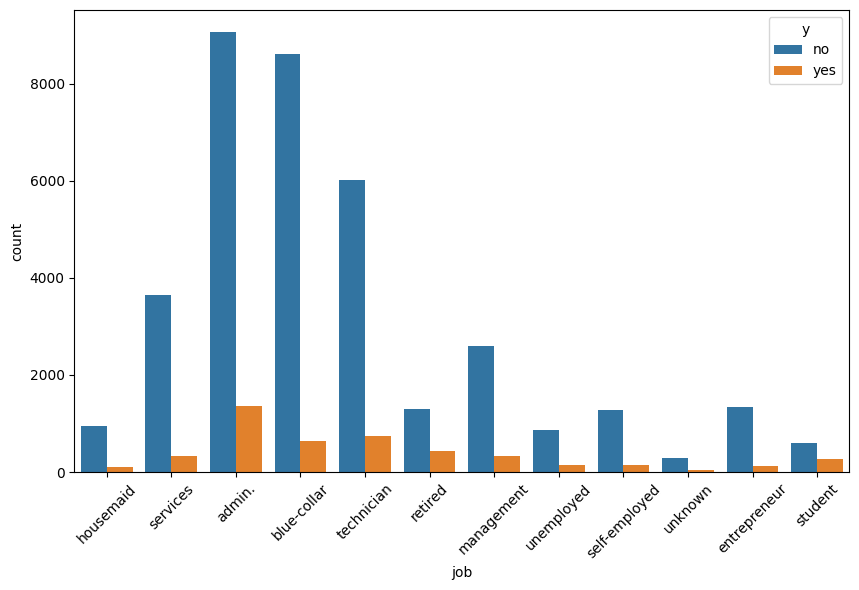

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(x='job', hue='y', data=data)
plt.xticks(rotation=45)
plt.show()

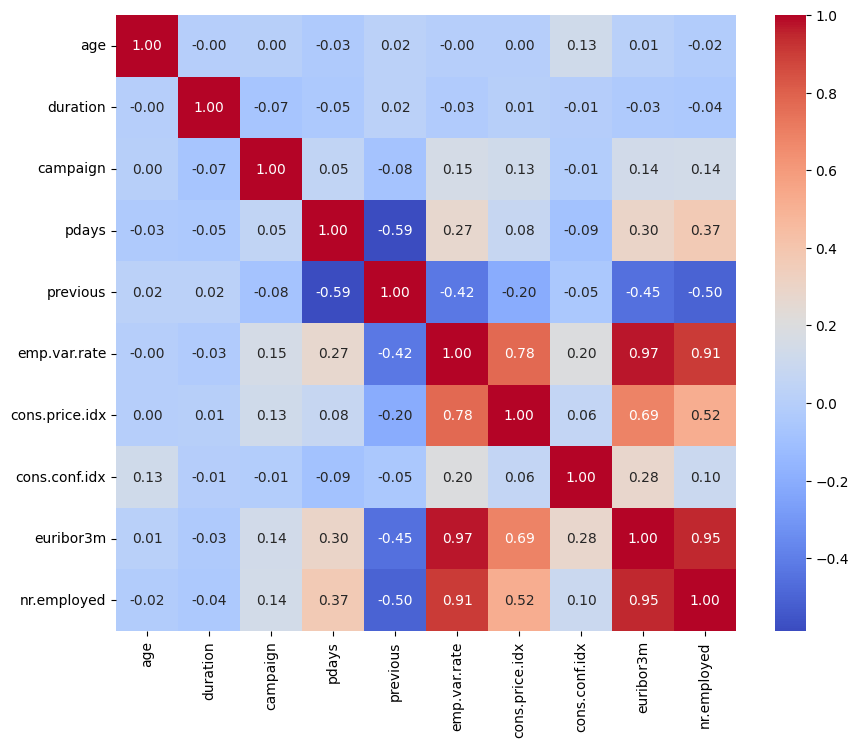

In [11]:
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns

numeric_data = data[numeric_columns]

corr_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()


#Data processing and transformation

In [45]:
X = data_cleaned.drop(columns=["y"])
y = data_cleaned["y"]

In [46]:
numeric_feats = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_feats = ['job', 'marital', 'default', 'housing', 'loan', 'poutcome']
ordinal_feats = ["education"]
education_levels = [
    'illiterate', 'basic.4y', 'basic.6y', 'basic.9y',
    'high.school', 'professional.course', 'university.degree', 'unknown'
]

In [47]:
preprocessor = ColumnTransformer(
    [
        ("imputeandscale", make_pipeline(SimpleImputer(), StandardScaler()), numeric_feats),
        ("onehot", OneHotEncoder(sparse=False), categorical_feats),
        ("ordinal", OrdinalEncoder(categories=[education_levels]), ordinal_feats),
    ]
)

In [48]:
X_processed = preprocessor.fit_transform(data)
X_processed

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[ 1.53303429,  0.01047142, -0.56592197, ...,  1.        ,
         0.        ,  1.        ],
       [ 1.62899323, -0.42150051, -0.56592197, ...,  1.        ,
         0.        ,  4.        ],
       [-0.29018564, -0.12451981, -0.56592197, ...,  1.        ,
         0.        ,  4.        ],
       ...,
       [ 1.53303429, -0.26722482, -0.20490853, ...,  1.        ,
         0.        ,  6.        ],
       [ 0.38152696,  0.70856893, -0.56592197, ...,  1.        ,
         0.        ,  5.        ],
       [ 3.26029527, -0.07438021,  0.15610492, ...,  0.        ,
         0.        ,  5.        ]])

In [49]:
column_names = (
    numeric_feats
    + preprocessor.named_transformers_["onehot"].get_feature_names_out().tolist()
    + ordinal_feats
)
column_names

['age',
 'duration',
 'campaign',
 'pdays',
 'cons.conf.idx',
 'nr.employed',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'default_no',
 'default_unknown',
 'default_yes',
 'housing_no',
 'housing_unknown',
 'housing_yes',
 'loan_no',
 'loan_unknown',
 'loan_yes',
 'poutcome_failure',
 'poutcome_nonexistent',
 'poutcome_success',
 'education']

In [50]:
named_transformers = preprocessor.named_transformers_

In [51]:
named_transformers

{'imputeandscale': Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())]),
 'onehot': OneHotEncoder(sparse=False, sparse_output=False),
 'ordinal': OrdinalEncoder(categories=[['illiterate', 'basic.4y', 'basic.6y', 'basic.9y',
                             'high.school', 'professional.course',
                             'university.degree', 'unknown']]),
 'remainder': 'drop'}

In [52]:
pd.DataFrame(X_processed, columns=column_names)

,age,duration,campaign,pdays,cons.conf.idx,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,poutcome_failure,poutcome_nonexistent,poutcome_success,education
0,1.533034,0.010471,-0.565922,0.195414,0.886447,0.331680,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.628993,-0.421501,-0.565922,0.195414,0.886447,0.331680,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0
2,-0.290186,-0.124520,-0.565922,0.195414,0.886447,0.331680,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0
3,-0.002309,-0.413787,-0.565922,0.195414,0.886447,0.331680,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0
4,1.533034,0.187888,-0.565922,0.195414,0.886447,0.331680,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,3.164336,0.292025,-0.565922,0.195414,-2.224953,-2.815697,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,5.0
41184,0.573445,0.481012,-0.565922,0.195414,-2.224953,-2.815697,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,5.0
41185,1.533034,-0.267225,-0.204909,0.195414,-2.224953,-2.815697,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,6.0
41186,0.381527,0.708569,-0.565922,0.195414,-2.224953,-2.815697,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,5.0


#Train and test models

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

##1. Linear Descriminant Analysis

In [54]:
lda_pipeline = Pipeline([
    ('lda', LDA(solver='lsqr'))
])

param_grid = {
    'lda__shrinkage': [None, 'auto', 0.1, 0.5, 0.9]
}

search = GridSearchCV(lda_pipeline, param_grid, cv=5)
search.fit(X_train, y_train)


print("Best parameters:", search.best_params_)

best_lda = search.best_estimator_
lda_train_score = best_lda.score(X_train, y_train)
lda_test_score = best_lda.score(X_test, y_test)

print("Accuracy on the train set with best parameters:", lda_train_score)
print("Accuracy on the test set with best parameters:", lda_test_score)


Best parameters: {'lda__shrinkage': 0.5}
Accuracy on the train set with best parameters: 0.9071927162367223
Accuracy on the test set with best parameters: 0.9101723719349356


##2. Logistic Regression

In [55]:
pipeline = Pipeline([
    ('classifier', LogisticRegression(max_iter=1000))
])

param_distributions = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

search = RandomizedSearchCV(pipeline, param_distributions, n_iter=5, cv=3, verbose=1, scoring='accuracy', n_jobs=-1, random_state=42)
search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('classifier',
                                              LogisticRegression(max_iter=1000))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'classifier__C': [0.01, 0.1, 1, 10],
                                        'classifier__penalty': ['l1', 'l2'],
                                        'classifier__solver': ['liblinear',
                                                               'saga']},
                   random_state=42, scoring='accuracy', verbose=1)

In [57]:
print("Best parameters:", search.best_params_)
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
logistic_regression_score = accuracy_score(y_test, y_pred)

print("Accuracy:", logistic_regression_score)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best parameters: {'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 0.1}
Accuracy: 0.9104151493080845
Confusion Matrix:
 [[7127  176]
 [ 562  373]]
Classification Report:
               precision    recall  f1-score   support

          no       0.93      0.98      0.95      7303
         yes       0.68      0.40      0.50       935

    accuracy                           0.91      8238
   macro avg       0.80      0.69      0.73      8238
weighted avg       0.90      0.91      0.90      8238



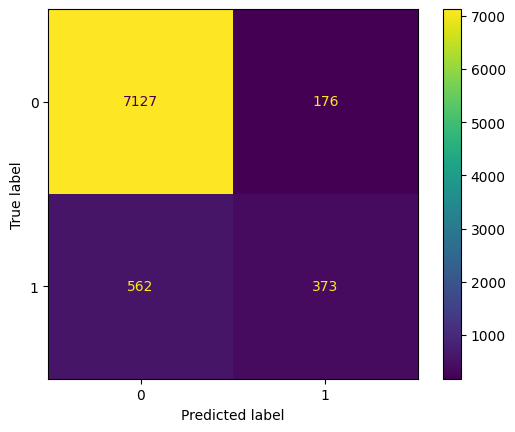

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = ConfusionMatrixDisplay.from_estimator(
    search, X_test, y_test, values_format="d", display_labels=[0, 1]
)

##3. KNN

In [59]:
knn = KNeighborsClassifier()
param_grid = {
    "n_neighbors": np.arange(1, 100)
}

In [60]:
random_search = RandomizedSearchCV(
    knn, param_grid, n_jobs=-1, n_iter=20, cv=5, random_state=42
)
random_search.fit(X_train, y_train);

In [61]:
results = pd.DataFrame(random_search.cv_results_).T
results

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
mean_fit_time,0.082534,0.077853,0.069001,0.081277,0.083032,0.071802,0.09218,0.07322,0.084464,0.0689,0.068256,0.09417,0.072111,0.084991,0.079087,0.086074,0.068006,0.068562,0.088763,0.072356
std_fit_time,0.019574,0.013391,0.005486,0.016989,0.023242,0.005386,0.029303,0.004069,0.020676,0.004285,0.003777,0.0284,0.003982,0.017834,0.019446,0.022131,0.00472,0.003554,0.02932,0.004221
mean_score_time,3.028116,3.373868,3.279823,3.042746,3.501885,3.122549,3.441283,3.075402,2.935149,3.200342,2.766939,3.511763,3.075364,3.067271,3.184714,2.784099,3.290311,2.647979,3.549354,3.366288
std_score_time,0.083237,0.415484,0.418332,0.315065,0.363908,0.207669,0.378217,0.314135,0.33771,0.724069,0.025627,0.621912,0.422907,0.333917,0.348347,0.316943,0.694638,0.029719,0.50891,0.490794
param_n_neighbors,63,41,96,19,98,85,65,43,11,1,32,77,48,27,45,5,23,13,89,74
params,{'n_neighbors': 63},{'n_neighbors': 41},{'n_neighbors': 96},{'n_neighbors': 19},{'n_neighbors': 98},{'n_neighbors': 85},{'n_neighbors': 65},{'n_neighbors': 43},{'n_neighbors': 11},{'n_neighbors': 1},{'n_neighbors': 32},{'n_neighbors': 77},{'n_neighbors': 48},{'n_neighbors': 27},{'n_neighbors': 45},{'n_neighbors': 5},{'n_neighbors': 23},{'n_neighbors': 13},{'n_neighbors': 89},{'n_neighbors': 74}
split0_test_score,0.906222,0.90698,0.90607,0.903945,0.906677,0.90698,0.905311,0.90698,0.899697,0.883763,0.904856,0.905311,0.90607,0.907587,0.90698,0.898179,0.906373,0.903187,0.907132,0.904704
split1_test_score,0.900152,0.898786,0.899241,0.90091,0.899545,0.9,0.900152,0.899545,0.897117,0.877845,0.900455,0.900303,0.898634,0.9,0.89909,0.896206,0.900607,0.898634,0.89909,0.899697
split2_test_score,0.903187,0.90349,0.90349,0.904401,0.903945,0.902883,0.903035,0.903945,0.900455,0.880577,0.904249,0.903035,0.903945,0.904856,0.904249,0.901214,0.905008,0.901973,0.90349,0.902731
split3_test_score,0.90698,0.908801,0.905615,0.908042,0.905159,0.906222,0.905918,0.908498,0.908801,0.88346,0.90956,0.906222,0.90698,0.907891,0.908042,0.90349,0.908042,0.907132,0.905766,0.906222


In [62]:
knn_score = random_search.best_score_
knn_score

0.9055235204855843

In [63]:
random_search.best_params_

{'n_neighbors': 23}

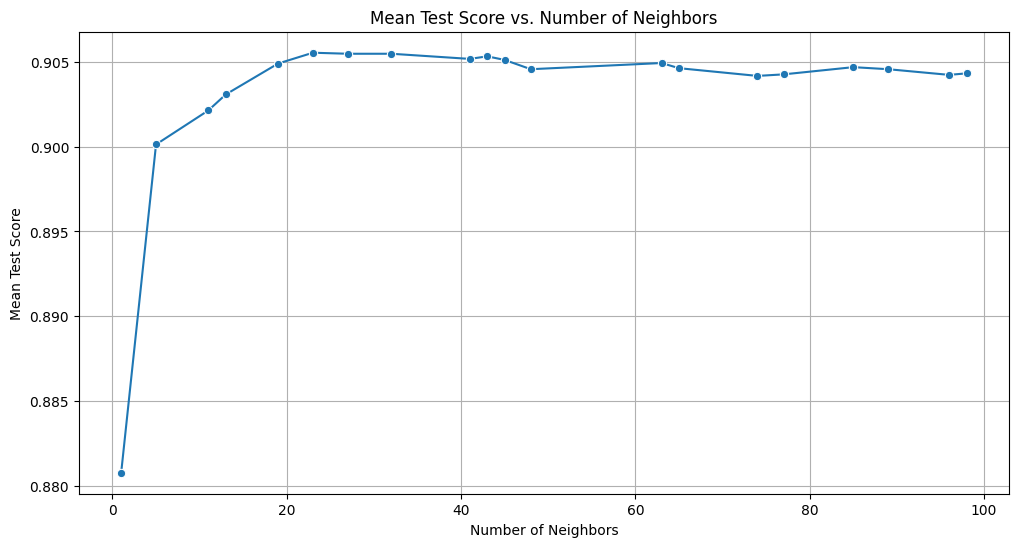

In [64]:
results = pd.DataFrame(random_search.cv_results_)

scores_df = pd.DataFrame({
    'n_neighbors': results['param_n_neighbors'],
    'mean_test_score': results['mean_test_score']
})

plt.figure(figsize=(12, 6))
sns.lineplot(data=scores_df, x='n_neighbors', y='mean_test_score', marker='o')
plt.title('Mean Test Score vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Test Score')
plt.grid(True)
plt.show()

##4. Decision Tree

In [66]:
depths = range(1, 21)
accuracy_scores = []

for depth in depths:
    tree_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree_model.fit(X_train, y_train)
    y_pred = tree_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f"Depth: {depth}, Accuracy: {accuracy}")

Depth: 1, Accuracy: 0.8865015780529255
Depth: 2, Accuracy: 0.9010682204418549
Depth: 3, Accuracy: 0.9089584850691915
Depth: 4, Accuracy: 0.9124787569798495
Depth: 5, Accuracy: 0.91442097596504
Depth: 6, Accuracy: 0.915877640203933
Depth: 7, Accuracy: 0.9142995872784656
Depth: 8, Accuracy: 0.9133284777858703
Depth: 9, Accuracy: 0.9101723719349356
Depth: 10, Accuracy: 0.9050740470988103
Depth: 11, Accuracy: 0.9047098810390871
Depth: 12, Accuracy: 0.902282107307599
Depth: 13, Accuracy: 0.8929351784413693
Depth: 14, Accuracy: 0.8937848992473901
Depth: 15, Accuracy: 0.8918426802621996
Depth: 16, Accuracy: 0.8914785142024764
Depth: 17, Accuracy: 0.8885651857246905
Depth: 18, Accuracy: 0.884316581694586
Depth: 19, Accuracy: 0.8815246419033747
Depth: 20, Accuracy: 0.8799465889779072


In [67]:
best_depth = depths[accuracy_scores.index(max(accuracy_scores))]
print(f"The best max_depth is {best_depth} with accuracy {max(accuracy_scores)}")

The best max_depth is 6 with accuracy 0.915877640203933


In [68]:
best_depth = 6
tree_model = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=42)

In [69]:
y_pred = tree_model.predict(X_test)
decision_tree_accuracy = accuracy_score(y_test, y_pred)
print(f"Reconfirmed Accuracy with best max_depth={best_depth}: {decision_tree_accuracy}")

Reconfirmed Accuracy with best max_depth=6: 0.915877640203933


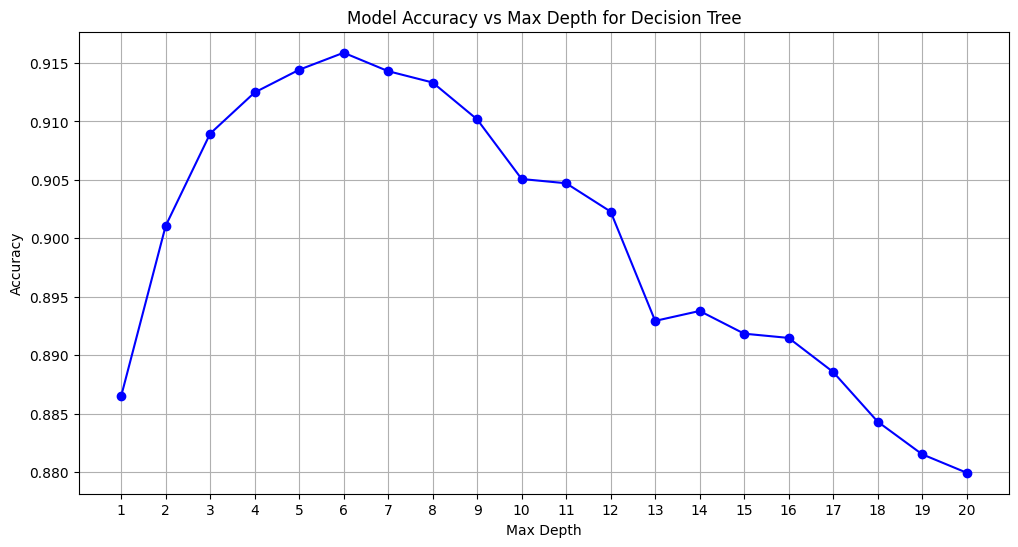

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(depths, accuracy_scores, marker='o', linestyle='-', color='blue')
plt.title('Model Accuracy vs Max Depth for Decision Tree')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.xticks(depths)
plt.grid(True)
plt.show()

##Random Forest

In [71]:
random_forest = RandomForestClassifier(random_state=42)

param_grid = {
    'max_depth': [10, 20, 30, 40, 50, 60]
}

In [72]:
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60]},
             scoring='accuracy')

In [72]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)

Best parameters: {'max_depth': 40}
Best cross-validated accuracy: 0.9115022761760242


In [73]:
best_random_forest = grid_search.best_estimator_
best_random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=40, random_state=42)

In [74]:
y_pred = best_random_forest.predict(X_test)
random_forest_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {random_forest_accuracy}")

Test set accuracy: 0.911750424860403


## Visualization for each model's score

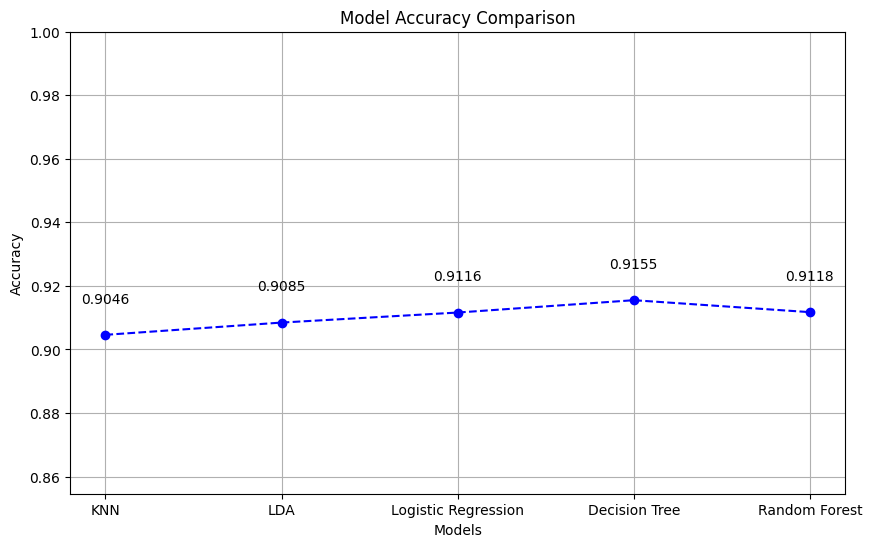

In [94]:
accuracy_scores = [knn_score, lda_test_score, logistic_regression_score, decision_tree_accuracy, random_forest_accuracy]

models = ['KNN', 'LDA', 'Logistic Regression', 'Decision Tree', 'Random Forest']

plt.figure(figsize=(10, 6))
plt.plot(models, accuracy_scores, marker='o', color='blue', linestyle='--')


plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim([min(accuracy_scores) - 0.05, 1])


for i in range(len(models)):
    plt.text(models[i], accuracy_scores[i]+ 0.01, f'{accuracy_scores[i]:.4f}', ha='center')

plt.grid(True)
plt.show()

###Conclusion: Among our five models, the Decision Tree Model displays the best accuracy with 0.9151.